### importing libraries

In [1]:
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
from pprint import pprint
import torchinfo
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision

In [2]:
#color_dict = {
#    'land'       : (133, 41 , 246),
#    'building'   : (60 , 16 , 152),
#    'road'       : (110, 193, 228),  
#    'vegetation' : (254, 221, 58 ),
#    'water'      : (226, 169, 41 ),
#    'unlabeled'  : (155, 155, 155)
#}

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
lr = 1e-4
batch_size = 16
img_height = 256
img_width = 256
pin_memory = True

img_dir = r'C:/Users/utkar/Desktop/ML/Dataset/aerial_img_4class/image'
mask_dir = r'C:/Users/utkar/Desktop/ML/Dataset/aerial_img_4class/mask'

In [5]:
n_classes = 6

colors = [(254, 221, 58), (226, 169, 41), (155, 155, 155), (132, 41, 246), (110, 193, 228), (60, 16, 152)]

def give_color_to_annotation(annotations):
    annotations = np.argmax(np.expand_dims(np.transpose(annotations, (1, 2, 0)), 0), 3)
    seg_img_6 = []
    for annotation in annotations:
        '''
        Converts a 2-D annotation(numpy array) with shape (height, width, 3) where
        the third axis represents the color channel. The label values are multiplied by
        255 and placed in this axis to give color to the annotation
        Args:
        annotation (numpy array) - label map array
        Returns:
        the annotation array with an additional color channel/axis
        '''
        seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
        for c in range(n_classes):
            segc = (annotation == c)
            seg_img[:,:,0] += segc*(colors[c][0])
            seg_img[:,:,1] += segc*(colors[c][1])
            seg_img[:,:,2] += segc*(colors[c][2])
        seg_img_6.append(seg_img)
  
    return np.array(seg_img_6)/255   # normalizing


def c3_to_classes(mask):
    '''
    converts rgb mask to tensor with shape(H, W, classes). Here we are taking advantage 
    of vlaue of R (RGb) of mask where no two value of R are similar to find the color.
    '''
    classes = 6
    mask_map = np.ones((256, 256, classes))
    mask_map[:, :, 0] = np.ones((256, 256))*(254)
    mask_map[:, :, 1] = np.ones((256, 256))*(226)
    mask_map[:, :, 2] = np.ones((256, 256))*(155)
    mask_map[:, :, 3] = np.ones((256, 256))*(132)
    mask_map[:, :, 4] = np.ones((256, 256))*(110)
    mask_map[:, :, 5] = np.ones((256, 256))*( 60)
    
    for i in range(6):
        mask_map[:, :, i] = (mask_map[:, :, i] == mask[:, :, 0])
    return mask_map

In [6]:
class ISDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        super(ISDataset, self)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img = os.listdir(img_dir)
        
    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img[index])
        mask_path = os.path.join(self.mask_dir, self.img[index].replace('.png', '_mask.png'))
        img = np.transpose((Image.open(img_path)), (2, 0, 1))
        mask = np.transpose(c3_to_classes(np.array(Image.open(mask_path))), (2, 0, 1))
        img = torch.tensor(img/255, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        return img, mask
    

ds = ISDataset(
    img_dir=img_dir,
    mask_dir=mask_dir,
)

In [8]:
train, val = train_test_split(ds, test_size=0.2, shuffle=True, )

In [9]:
np.shape(train), np.shape(val)

((225, 2), (57, 2))

In [10]:
train_loader = DataLoader(
    train,
    batch_size=batch_size,
    pin_memory=pin_memory,
    shuffle=True
)

val_loader = DataLoader(
    val,
    batch_size=batch_size,
    pin_memory=pin_memory,
    shuffle=False
)

In [11]:
img, mask = train_loader.dataset[0]
img.shape, mask.shape

(torch.Size([3, 256, 256]), torch.Size([6, 256, 256]))

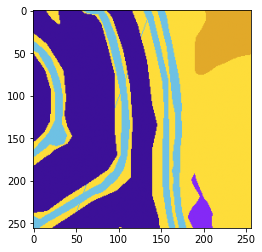

In [12]:
mask_color = give_color_to_annotation(mask)
plt.imshow(np.squeeze(mask_color, 0))
plt.show()

In [13]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )
    return conv

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv1 = double_conv(3, 64)
        self.down_conv2 = double_conv(64, 128)
        self.down_conv3 = double_conv(128, 256)
        self.down_conv4 = double_conv(256, 512)
        self.down_conv5 = double_conv(512, 1024)
        
        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2)
        
        self.up_conv_1 = double_conv(1024, 512)
        
        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2)
        
        self.up_conv_2 = double_conv(512, 256)
        
        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2)
        
        self.up_conv_3 = double_conv(256, 128)
        
        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2)
        
        self.up_conv_4 = double_conv(128, 64)
        
        self.out = nn.Conv2d(64, 6, kernel_size=1)
        
    def forward(self, img):
        # encoding
        x1 = self.down_conv1(img)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv5(x8)
        
        # decoding
        x = self.up_trans_1(x9)
        x = self.up_conv_1(torch.concat([x, x7], 1))
        x = self.up_trans_2(x)
        x = self.up_conv_2(torch.concat([x, x5], 1))
        x = self.up_trans_3(x)
        x = self.up_conv_3(torch.concat([x, x3], 1))
        x = self.up_trans_4(x)
        x = self.up_conv_4(torch.concat([x, x1], 1))
        x = self.out(x)
        #print(x.shape)
        return x

In [14]:
model = Unet().to(device)

In [15]:
#pprint(torchinfo.summary(model, input_size=(1, 3, 256, 256)))

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scaler = torch.cuda.amp.GradScaler()   # to avoid vanishing gradient problem

In [17]:
def draw():    
    with torch.no_grad():
        n = np.random.randint(0, 57)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
        img, target = val_loader.dataset[n]
        axes[0].imshow(give_color_to_annotation(target)[0])
        img = torch.unsqueeze(img, 0)
        mask_output = model(img.to('cuda'))
        axes[1].imshow(give_color_to_annotation(mask_output[0].to('cpu'))[0])
        plt.show()
        
def check_acc(loader, model, device='cuda'):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)   # returns product of the values in tensor
            
    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    model.train()

100%|████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.42it/s, loss=1.5]


Got 12914169/22413312 with acc 57.62
epoch 1


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.04it/s, loss=0.697]


Got 11064328/22413312 with acc 49.36
epoch 2


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.03it/s, loss=1.23]


Got 11440486/22413312 with acc 51.04
epoch 3


100%|████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.03it/s, loss=1.4]


Got 14922181/22413312 with acc 66.58
epoch 4


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.03it/s, loss=1.12]


Got 17498975/22413312 with acc 78.07
epoch 5


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.03it/s, loss=1.04]


Got 17820426/22413312 with acc 79.51
epoch 6


100%|██████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.02it/s, loss=1]


Got 17809576/22413312 with acc 79.46
epoch 7


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.02it/s, loss=1.45]


Got 18084535/22413312 with acc 80.69
epoch 8


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.02it/s, loss=1.27]


Got 17657573/22413312 with acc 78.78
epoch 9


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.02it/s, loss=1.27]


Got 18159351/22413312 with acc 81.02
epoch 10


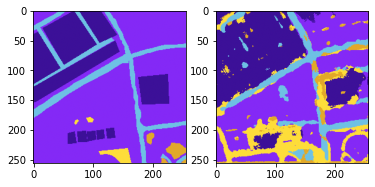

100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.02it/s, loss=1.04]


Got 17412716/22413312 with acc 77.69
epoch 11


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.02it/s, loss=1.16]


Got 18617415/22413312 with acc 83.06
epoch 12


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.02it/s, loss=1.02]


Got 18626618/22413312 with acc 83.11
epoch 13


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.02it/s, loss=0.894]


Got 18379281/22413312 with acc 82.00
epoch 14


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.02it/s, loss=1.14]


Got 18361965/22413312 with acc 81.92
epoch 15


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.02it/s, loss=0.546]


Got 18407437/22413312 with acc 82.13
epoch 16


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.02it/s, loss=0.741]


Got 18375997/22413312 with acc 81.99
epoch 17


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=0.972]


Got 17601655/22413312 with acc 78.53
epoch 18


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=1.18]


Got 18459546/22413312 with acc 82.36
epoch 19


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=1.09]


Got 19069866/22413312 with acc 85.08
epoch 20


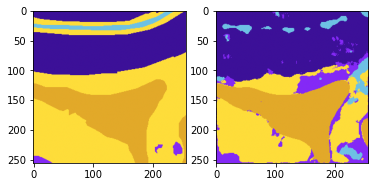

100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=1.57]


Got 19408169/22413312 with acc 86.59
epoch 21


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=0.821]


Got 19202648/22413312 with acc 85.68
epoch 22


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=1.52]


Got 18938754/22413312 with acc 84.50
epoch 23


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=0.689]


Got 19225131/22413312 with acc 85.78
epoch 24


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=1.14]


Got 19036829/22413312 with acc 84.94
epoch 25


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=0.984]


Got 19393203/22413312 with acc 86.53
epoch 26


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=0.978]


Got 18994512/22413312 with acc 84.75
epoch 27


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=0.697]


Got 18540663/22413312 with acc 82.72
epoch 28


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=0.735]


Got 18827892/22413312 with acc 84.00
epoch 29


100%|████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=1.4]


Got 19137170/22413312 with acc 85.38
epoch 30


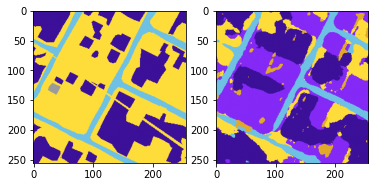

100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=0.908]


Got 18966349/22413312 with acc 84.62
epoch 31


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=1.37]


Got 19058981/22413312 with acc 85.03
epoch 32


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=1.13]


Got 18881865/22413312 with acc 84.24
epoch 33


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.00it/s, loss=0.433]


Got 19041077/22413312 with acc 84.95
epoch 34


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.00it/s, loss=1.28]


Got 18885129/22413312 with acc 84.26
epoch 35


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=1.58]


Got 18962945/22413312 with acc 84.61
epoch 36


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.00it/s, loss=1.06]


Got 19299745/22413312 with acc 86.11
epoch 37


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=1.02]


Got 18752296/22413312 with acc 83.67
epoch 38


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.00it/s, loss=0.958]


Got 18505487/22413312 with acc 82.56
epoch 39


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.00it/s, loss=1.09]


Got 18686427/22413312 with acc 83.37
epoch 40


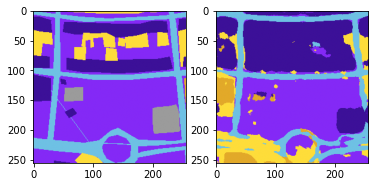

100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=0.668]


Got 19009214/22413312 with acc 84.81
epoch 41


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.00it/s, loss=1.01]


Got 19085409/22413312 with acc 85.15
epoch 42


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=0.725]


Got 19085697/22413312 with acc 85.15
epoch 43


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=1.06]


Got 18762722/22413312 with acc 83.71
epoch 44


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=0.485]


Got 17936459/22413312 with acc 80.03
epoch 45


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=1.13]


Got 19228857/22413312 with acc 85.79
epoch 46


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=1.05]


Got 19047951/22413312 with acc 84.98
epoch 47


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=0.708]


Got 19023086/22413312 with acc 84.87
epoch 48


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.00it/s, loss=0.804]


Got 19592873/22413312 with acc 87.42
epoch 49


100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.01it/s, loss=0.501]


Got 18715674/22413312 with acc 83.50
epoch 50


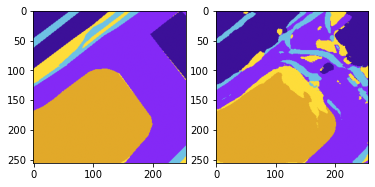

In [18]:
epochs = 50
model.train()

for epoch in range(epochs):
    # training
    loop = tqdm(train_loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        target = targets.float().to('cuda')
        
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data).to('cuda')
            loss = loss_fn(predictions, target)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        #update tqdm loop
        loop.set_postfix(loss=loss.item())
    
        # checcking accuracy
    check_acc(val_loader, model, device=device)
    print(f'epoch {epoch+1}')
    if (epoch+1)%10 == 0:
        draw()
        

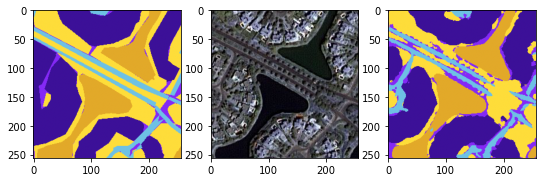

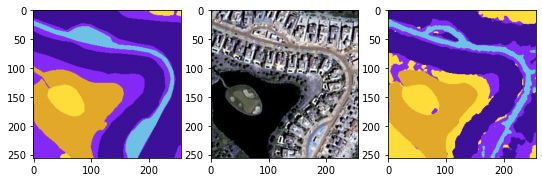

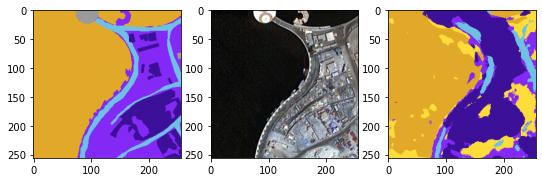

In [26]:
with torch.no_grad():
    for i in range(3):
        n = np.random.randint(0, 57)
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,3))
        img, target = val_loader.dataset[n]
        axes[0].imshow(give_color_to_annotation(target)[0])
        axes[1].imshow(img.permute(1, 2, 0))
        img = torch.unsqueeze(img, 0)
        mask_output = model(img.to('cuda'))
        axes[2].imshow(give_color_to_annotation(mask_output[0].to('cpu'))[0])
        plt.show()

In [19]:
!nvidia-smi

Tue Jun 14 16:32:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.79       Driver Version: 511.79       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8    13W /  N/A |   5354MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------